В данной лабораторной работе решается здача корректировки контрастности изображения с использованием трёх методов - 
Линейное растяжение, Эквализация, Приведение гистограммы.

Для проведения преобразований в качестве исходного изображения было выбрано такое, гистограмма которого смещена ближе к центру. В ходе лабораторной работы рассматривается обработка изображения по одному цетовому каналу, в связи с этим, решено приводить выходные изображения в серую цветовоую гамму.

In [5]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np

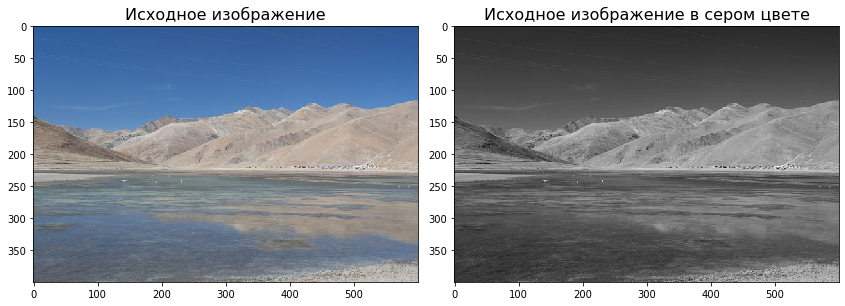

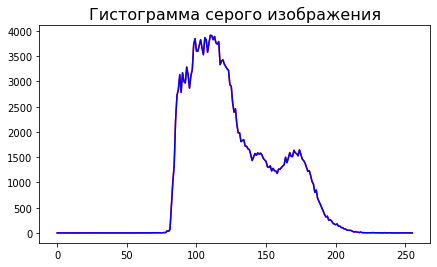

In [11]:
img = cv.imread('res/1.jpg')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)


def calculateHistogram(img) :
    hist = np.zeros(256)
    for i in img :
        for j in i :
            hist[j] += 1
    return hist


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(img) 
axes[0].set_title('Исходное изображение', fontsize=16)
axes[1].imshow(img_gray, cmap='gray')
axes[1].set_title('Исходное изображение в сером цвете', fontsize=16)
fig.tight_layout()

custom_origin_hist = calculateHistogram(img_gray)
origin_hist = cv.calcHist([img_gray],[0],None,[256],[0,256])

plt.figure(figsize=(7, 4))
plt.title('Гистограмма серого изображения', fontsize=16)
plt.plot(custom_origin_hist, color='r')
plt.plot(origin_hist, color='b')
plt.show()

Гистограммы посчитанные собственным методом и методом из opencv совпадают, далее будет использоваться только opencv.

Первый способ обработки контрастности изображения - линейное растяжение. Для этого разработана функция, которая растягивает гистограмму и применяет изменения к изображению. Также в дополнение разработана функция, которая позволяет превратить указанное число процентов гистограммы либо в чёрный цвет, либо в белый. Эмпирически было выявленно, что наиболее оптимальным значением для параметра per - является 5%.

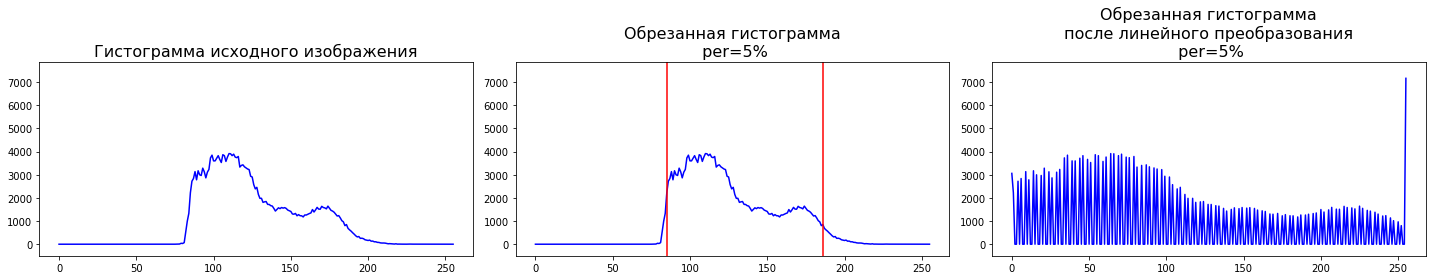

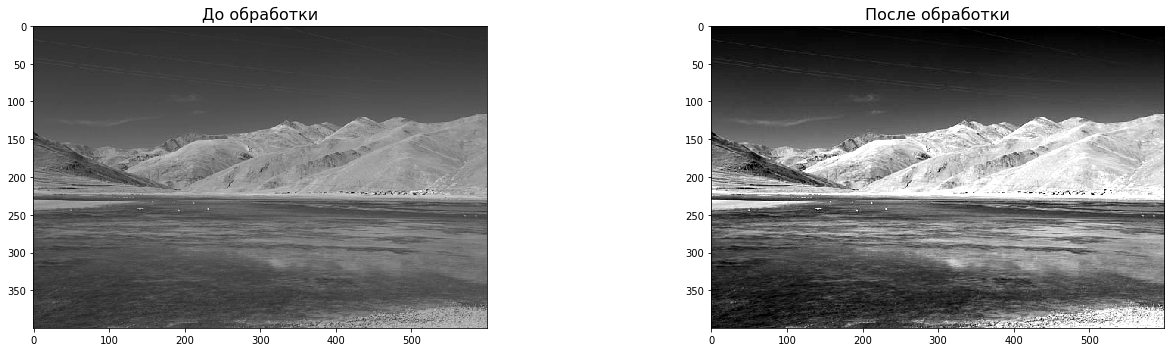

In [16]:
img = cv.imread('res/1.jpg', cv.IMREAD_GRAYSCALE)


def linearStretching(img, borders) :
    left_b, right_b = borders
    mapColor = np.zeros(shape=(256,1))
    for i in range(left_b, right_b) :       
        mapColor[i] = round((i - left_b) * 254 / (right_b - left_b) + 0) + 1
    for i in range(right_b, 255) :
        mapColor[i] = 255

    mapColor_m = np.ma.masked_equal(mapColor.flatten(), 0)
    mapColor = np.ma.filled(mapColor_m, 0).astype('uint8')
    
    return mapColor[img]


def cutImgHist(img, per=1) :
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    max_border_value = sum(hist) * per / 100
    
    left_b = -1; right_b = 256
    left_v = 0; right_v = 0
    while left_v + right_v <= max_border_value :
        if hist[right_b - 1] + right_v > hist[left_b + 1] + left_v :
            left_v += hist[left_b + 1]
            left_b += 1
        else :
            right_v += hist[right_b - 1]
            right_b -= 1

    return left_b, right_b


per = 5

left_b, right_b = cutImgHist(img, per)
img_linear = linearStretching(img, (left_b, right_b))
linear_hist = cv.calcHist([img_linear],[0],None,[256],[0,256])
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
axes[0].plot(origin_hist, color = 'b') 
axes[0].set_title('Гистограмма исходного изображения', fontsize=16)
axes[1].plot(origin_hist, color = 'b')
axes[1].axvline(x=left_b, color='r')
axes[1].axvline(x=right_b, color='r')
axes[1].set_title('Обрезанная гистограмма\n per=' + str(per) + '%', fontsize=16)
axes[2].plot(linear_hist, color = 'b') 
axes[2].set_title('Обрезанная гистограмма\nпосле линейного преобразования\n per=' + str(per) + '%', fontsize=16)
max_v = max(linear_hist); max_v += max_v * 0.1
axes[0].set_ylim((-500,max_v)); axes[1].set_ylim((-500,max_v)); axes[2].set_ylim((-500,max_v))
fig.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('До обработки', fontsize=16)
axes[1].imshow(img_linear, cmap='gray')
axes[1].set_title('После обработки', fontsize=16)
fig.tight_layout()

Следующий метод обаботки контрастности изображения, который планируется использовать - это эквализация. Для этого разработана функция, которая вычисляет кумулятивную гистограмму и проводит преобразования, направленные на приведение её к виду прямой. Кумулятивные гистограммы приведены в нормализованном виде.

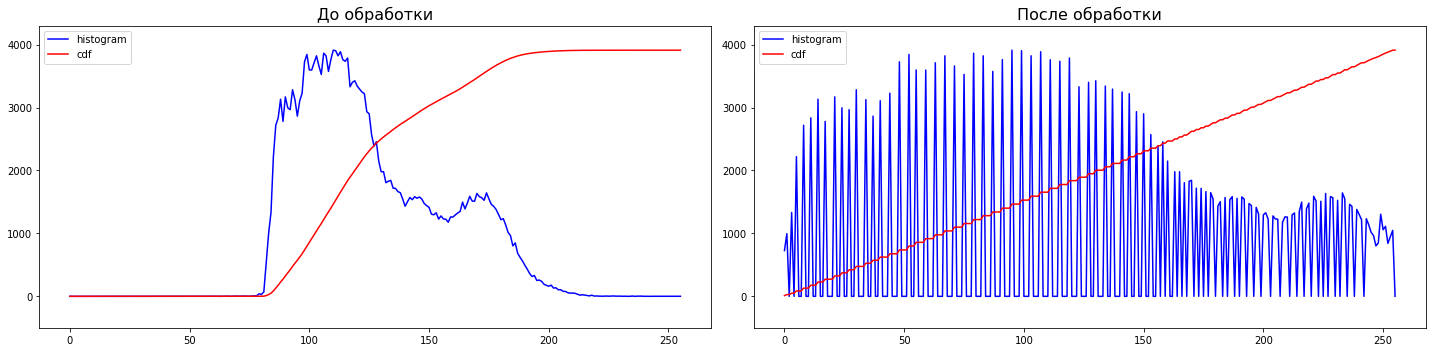

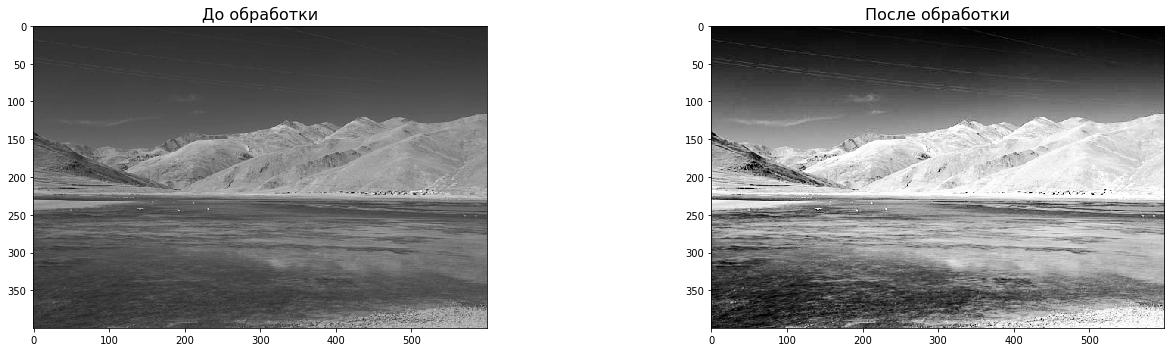

In [17]:
img = cv.imread('res/1.jpg', cv.IMREAD_GRAYSCALE)


def equalization(img) :
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    
    return cdf[img]


hist = cv.calcHist([img],[0],None,[256],[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

img_equal = equalization(img)

equal_hist = cv.calcHist([img_equal],[0],None,[256],[0,256])
cdf_equal = equal_hist.cumsum()
cdf_normalized_equal = cdf_equal * equal_hist.max() / cdf_equal.max()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].plot(hist, color = 'b')
axes[0].plot(cdf_normalized, color = 'r')
axes[0].legend(('histogram','cdf'), loc = 'upper left')
axes[0].set_title('До обработки', fontsize=16)
axes[1].plot(equal_hist,color = 'b')
axes[1].plot(cdf_normalized_equal, color = 'r')
axes[1].legend(('histogram','cdf'), loc = 'upper left')
axes[1].set_title('После обработки', fontsize=16)
max_v = max(hist); max_v += max_v * 0.1
axes[0].set_ylim((-500,max_v)); axes[1].set_ylim((-500,max_v))
fig.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('До обработки', fontsize=16)
axes[1].imshow(img_equal, cmap='gray')
axes[1].set_title('После обработки', fontsize=16)
fig.tight_layout()

Результаты полученные с помощью линейного преобразования и эквализации приведены рядом, для более детального сравнения. Стоит заметить, что в нашем случае изображение полученное, с помощью эквализации оказалось более осветленным. Также для метода эквализации не требуется предварительно образать изображение, что влияет на конечную контрастность изорабжения. Для метода линейного растяжения контрастность выше, так как
часть пикселей переходит в цвета 0 и 255.

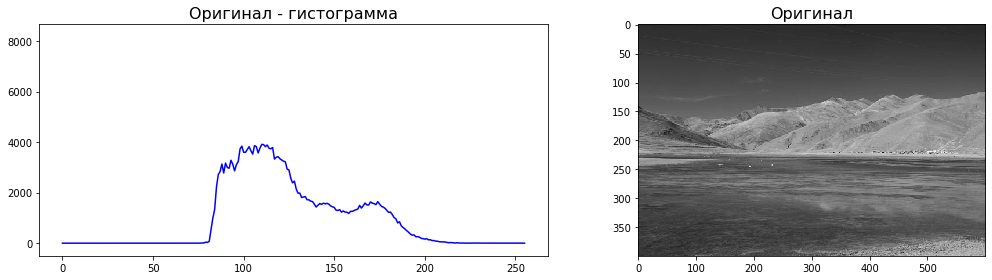

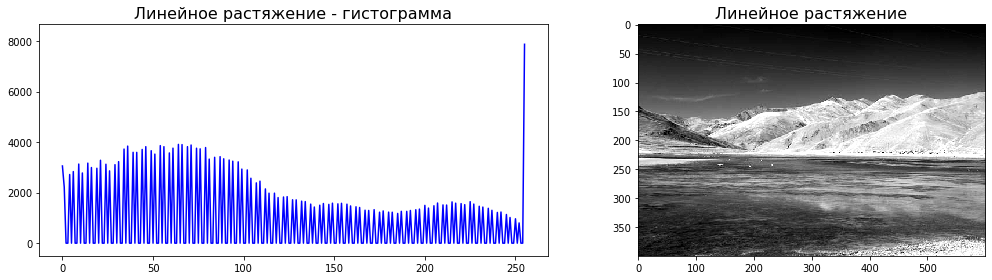

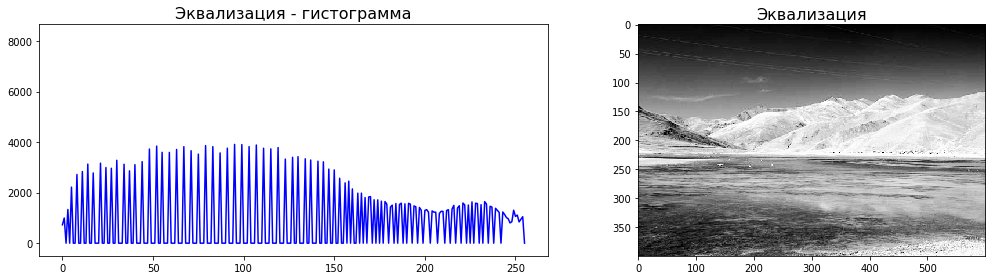

In [18]:
max_v = max(max(origin_hist), max(linear_hist), max(equal_hist))[0]
max_v += max_v * 0.1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(origin_hist, color = 'b')
axes[1].imshow(img_gray, cmap='gray')
axes[0].set_title('Оригинал - гистограмма', fontsize=16)
axes[1].set_title('Оригинал', fontsize=16)
axes[0].set_ylim((-500,max_v))
fig.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(linear_hist, color = 'b')
axes[1].imshow(img_linear, cmap='gray')
axes[0].set_title('Линейное растяжение - гистограмма', fontsize=16)
axes[1].set_title('Линейное растяжение', fontsize=16)
axes[0].set_ylim((-500,max_v))
fig.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(equal_hist, color = 'b')
axes[1].imshow(img_equal, cmap='gray')
axes[0].set_title('Эквализация - гистограмма', fontsize=16)
axes[1].set_title('Эквализация', fontsize=16)
axes[0].set_ylim((-500,max_v))
fig.tight_layout()


Для методов линейного растяжения и эквализации перепробавано около 150 изображений. Представлены результаты, на которых эффект от обработки и разница эффектов двух методов наиболее высоки.


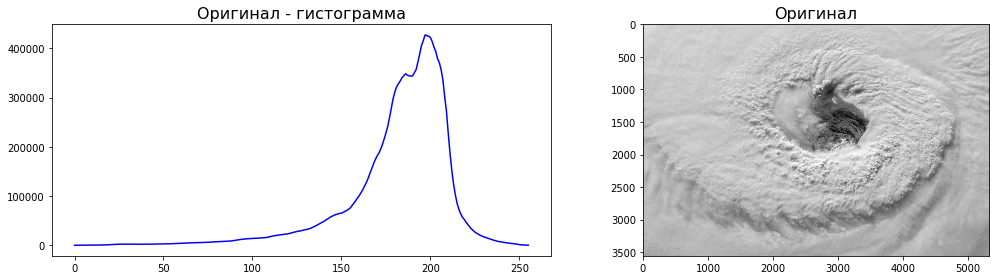

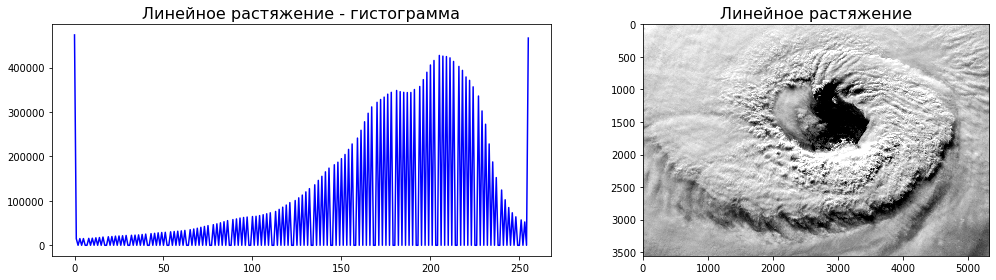

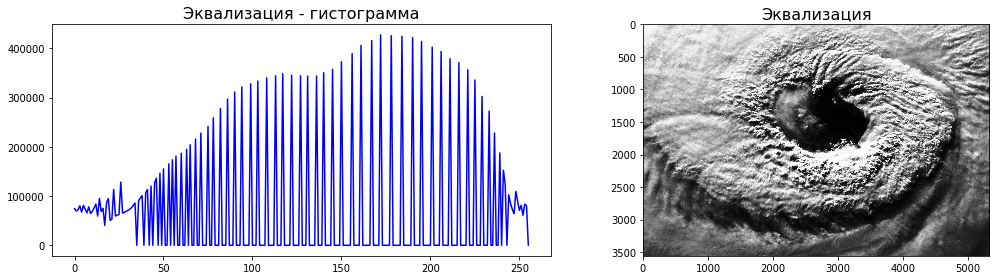

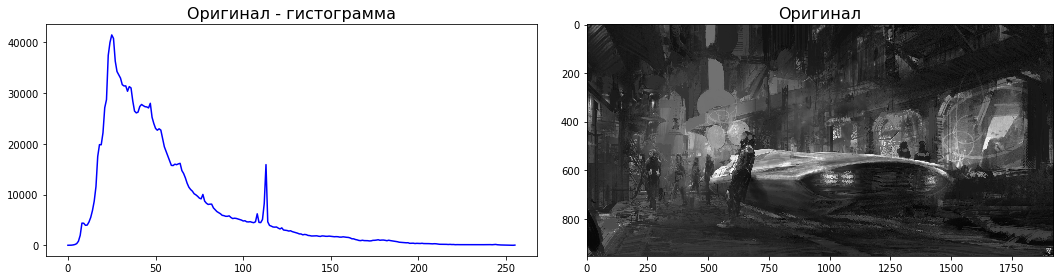

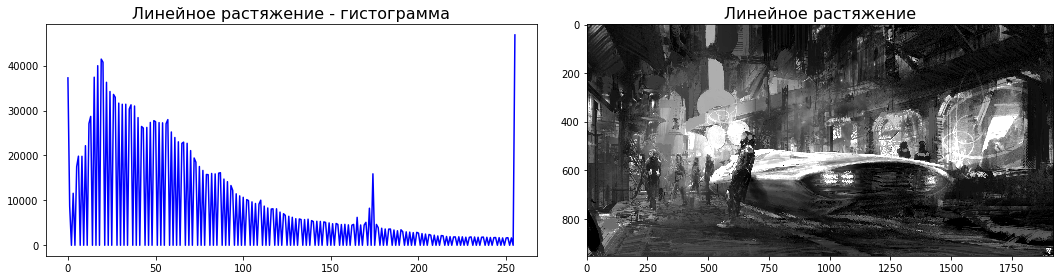

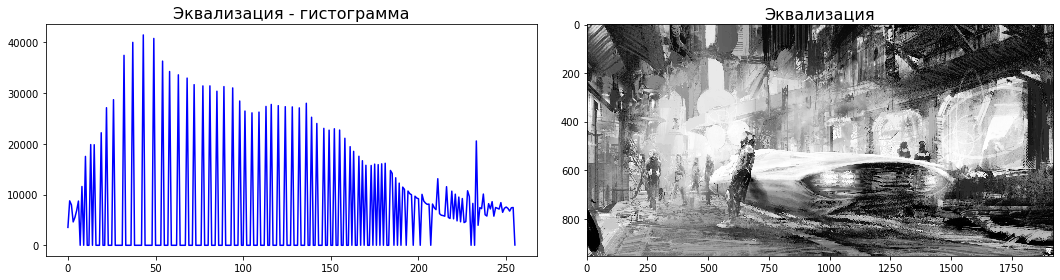

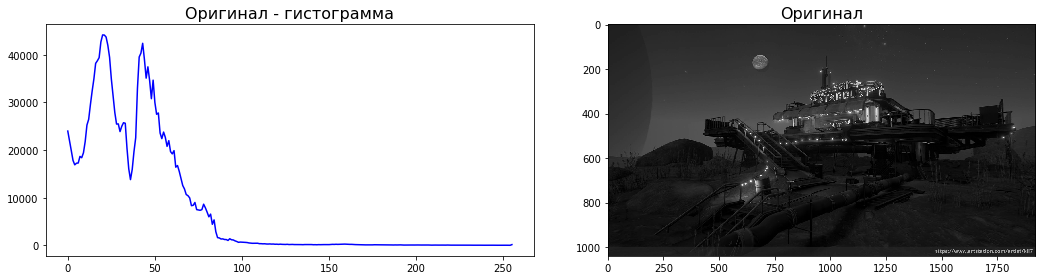

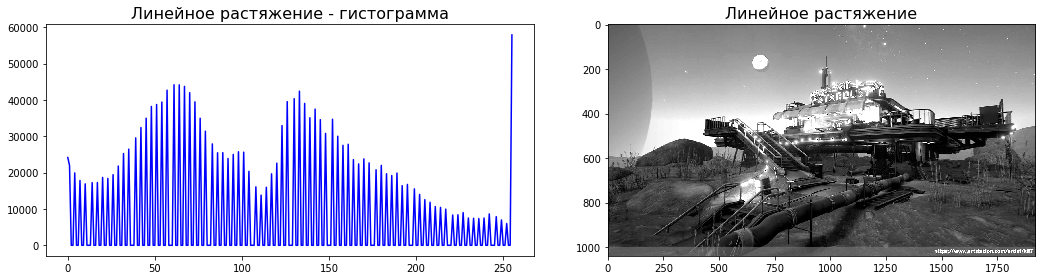

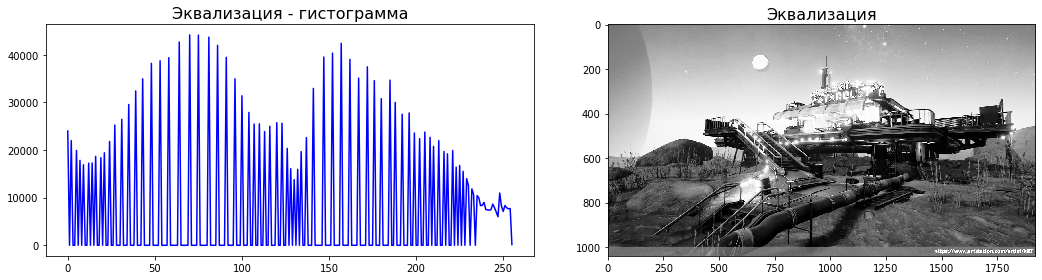

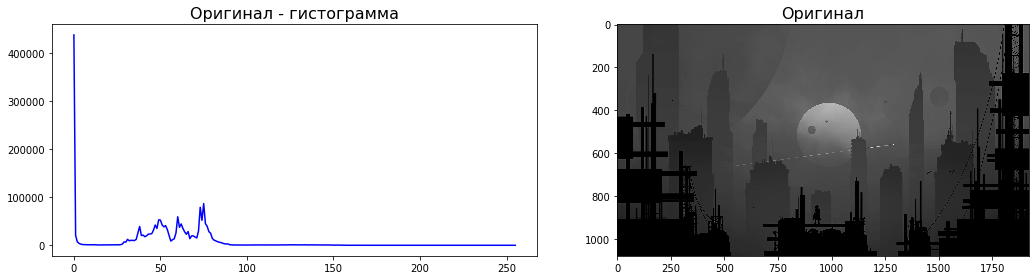

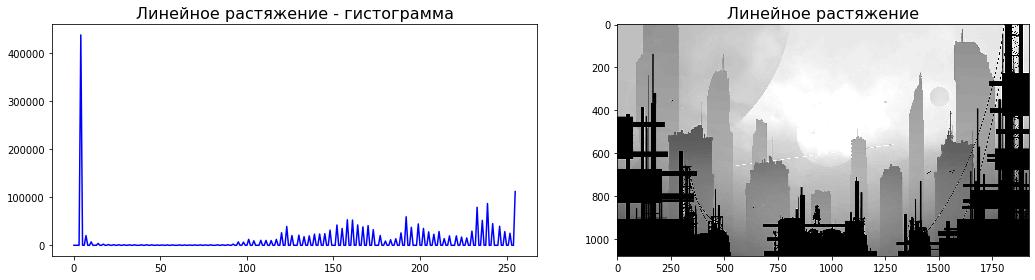

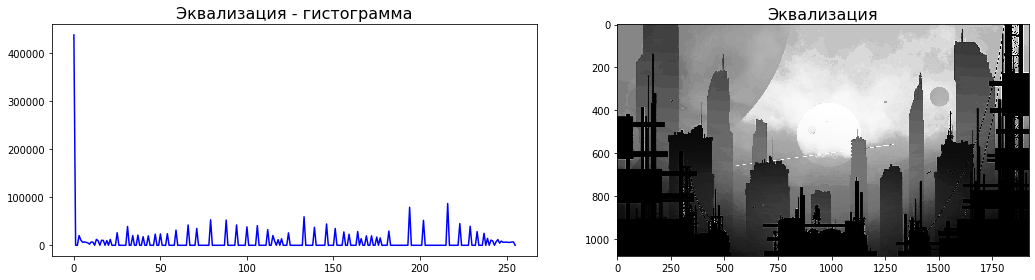

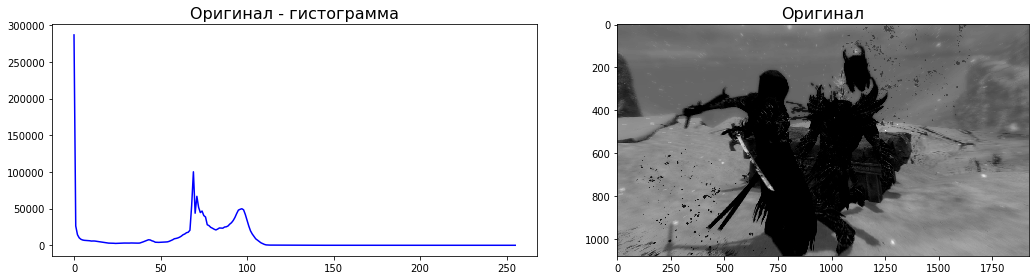

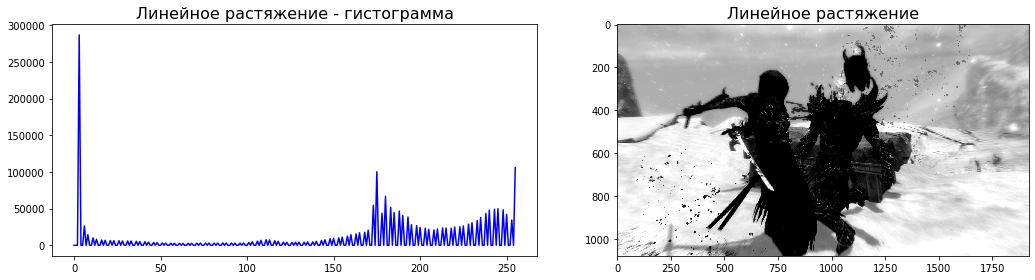

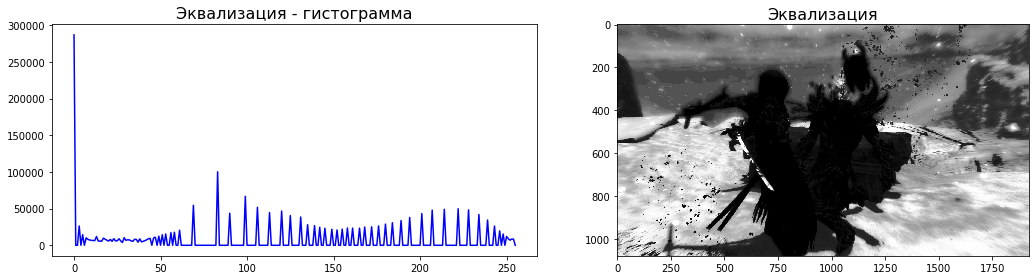

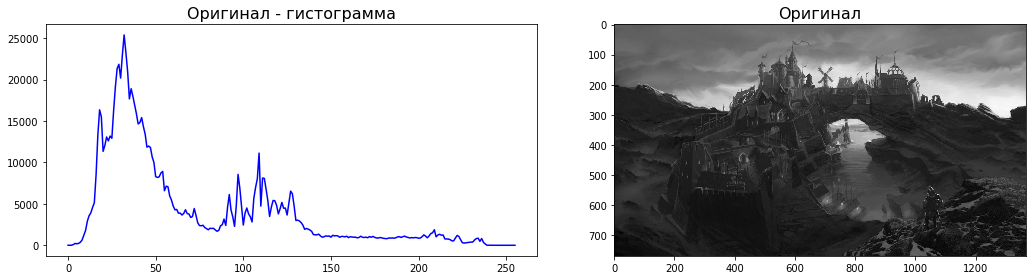

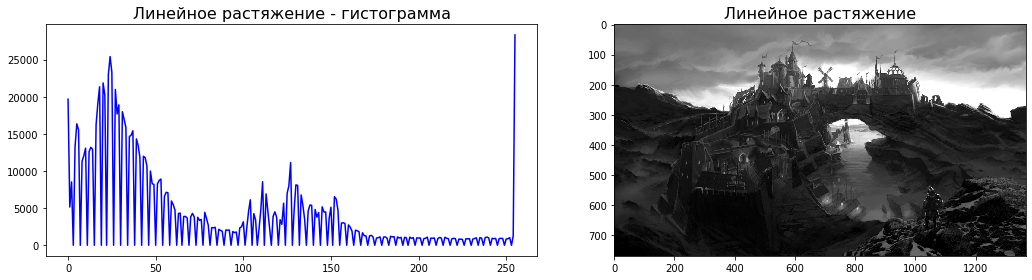

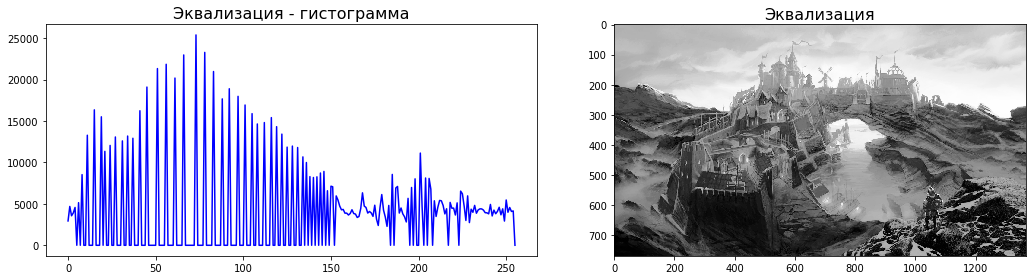

In [167]:
per = 5

img_names = ['res/2.jpg', 'res/4.jpg',
             'res/5.jpg', 'res/7.jpg',
             'res/8.jpg', 'res/9.jpg']

for img_name in img_names :
    img = cv.imread(img_name, cv.IMREAD_GRAYSCALE)
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    
    img_linear = linearStretching(img, cutImgHist(img, per))
    liner_hist = cv.calcHist([img_linear],[0],None,[256],[0,256])
    
    img_equal = equalization(img)
    equal_hist = cv.calcHist([img_equal],[0],None,[256],[0,256])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    axes[0].plot(hist, color = 'b')
    axes[1].imshow(img, cmap='gray')
    axes[0].set_title('Оригинал - гистограмма', fontsize=16)
    axes[1].set_title('Оригинал', fontsize=16)
    fig.tight_layout()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    axes[0].plot(liner_hist, color = 'b')
    axes[1].imshow(img_linear, cmap='gray')
    axes[0].set_title('Линейное растяжение - гистограмма', fontsize=16)
    axes[1].set_title('Линейное растяжение', fontsize=16)
    fig.tight_layout()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    axes[0].plot(equal_hist, color = 'b')
    axes[1].imshow(img_equal, cmap='gray')
    axes[0].set_title('Эквализация - гистограмма', fontsize=16)
    axes[1].set_title('Эквализация', fontsize=16)
    fig.tight_layout()


Следующий рассматриваемый метод обработки изображений - приведение кумулятивной гистограммы. Проводимые действия подобны предыдущему методу, но в отличие от эквализации, в этом методе приведение кумулятивной гистограммы идёт не к прямой линии, а к кумулятивной гистограмме другого изорабжения.

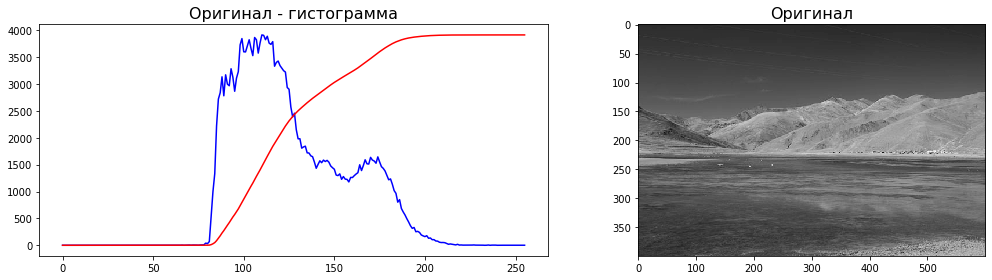

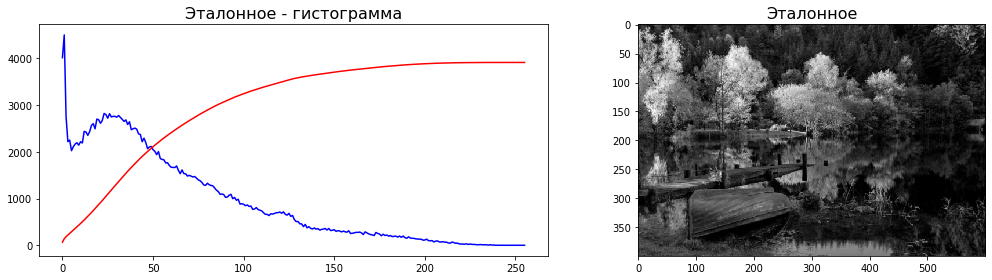

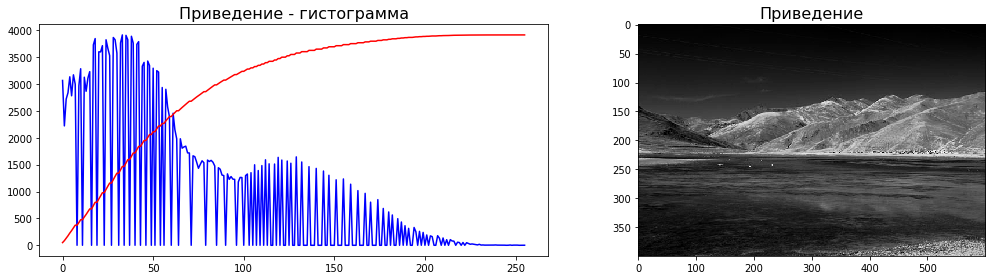

In [169]:
img = cv.imread('res/1.jpg', cv.IMREAD_GRAYSCALE)
img = cv.imread('res/12.jpg', cv.IMREAD_GRAYSCALE)


def reductionHists(img, img_ref) :
    if img.shape != img_ref.shape :
        return img
    
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    cdf = hist.cumsum()
    hist_ref = cv.calcHist([img_ref],[0],None,[256],[0,256])
    cdf_ref = hist_ref.cumsum()
    
    mapColor = np.zeros(shape=(256,1))
    
    x = 0    
    for i, val_1 in enumerate(cdf) :
        n_min = val_1
        k_min = (0,0)
        for j, val_2 in enumerate(cdf_ref) :
            if abs(val_1 - val_2) < n_min and j > x  : 
                n_min = abs(val_1 - val_2)
                k_min = (i,j)
                x = j
        if k_min != (0,0) :
            mapColor[k_min[0]] = k_min[1]
            
    mapColor_m = np.ma.masked_equal(mapColor.flatten(),0)
    mapColor = np.ma.filled(mapColor_m,0).astype('uint8')
    
    return mapColor[img]


hist1 = cv.calcHist([img1],[0],None,[256],[0,256])
cdf1 = hist1.cumsum()
cdf_normalize1 = cdf1 * hist1.max() / cdf1.max()

hist2 = cv.calcHist([img2],[0],None,[256],[0,256])
cdf2 = hist2.cumsum()
cdf_normalize2 = cdf2 * hist1.max() / cdf2.max()

img_reduct = reductionHists(img1,img2)

hist_reduct = cv.calcHist([img_reduct],[0],None,[256],[0,256])
cdf_reduct = hist_reduct.cumsum()
cdf_normalize_reduct = cdf_reduct * hist1.max() / cdf_reduct.max()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(hist1, color = 'b')
axes[0].plot(cdf_normalize1, color = 'r')
axes[1].imshow(img1, cmap='gray')
axes[0].set_title('Оригинал - гистограмма', fontsize=16)
axes[1].set_title('Оригинал', fontsize=16)
fig.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(hist2, color = 'b')
axes[0].plot(cdf_normalize2, color = 'r')
axes[1].imshow(img2, cmap='gray')
axes[0].set_title('Эталонное - гистограмма', fontsize=16)
axes[1].set_title('Эталонное', fontsize=16)
fig.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(hist_reduct, color = 'b')
axes[0].plot(cdf_normalize_reduct, color = 'r')
axes[1].imshow(img_reduct, cmap='gray')
axes[0].set_title('Приведение - гистограмма', fontsize=16)
axes[1].set_title('Приведение', fontsize=16)
fig.tight_layout()

Рассмотренные в ходе работы методы позволяют влиять на вид гистограммы изображения, тем самым изменяя его контрастность.
Метод линейного растяжения для усиления эффекта преобразования требует предварительного обрезания гистограммы изображения,
что увеличивает контрастность слишком резко. Метод эквализации, в некоторых приведеных эксперименах, излишне осветялет
изображение, что приводит к ухудшению качества восприятия. В целом оба метода показывают наибольшую эффективность на изображении
гистограмма которого изначально сконцентрирована в небольшой облатси. Одно из отличий линейного растяжения от эквализации - это то,
что в первом случае наибольший эффект достигается при узком диапазоне, а во втором это не почти не важно.
Метод основанный на приведение гистограммы к эталонному виду позволяет получить возможность управлять контрастностью, в приведенном
эксперименте это делается с помощью другого изображения. Продемонстрировано, что контрастность исходного изображения изменяется в
сторону эталонного изображения.